In [1]:
# Import from Qiskit
from qiskit import BasicAer , Aer , IBMQ
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, TwoLocal, ExcitationPreserving
from qiskit.utils import QuantumInstance

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.opflow import Z2Symmetries
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
#from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.algorithms import VQE, NumPyEigensolver, NumPyMinimumEigensolver
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers import UnitsType
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.settings import settings
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.second_q.transformers import FreezeCoreTransformer

# Import from other python libraries
import numpy as np
import matplotlib . pyplot as plt
import pylab as py

In [2]:
dist = 0.74
basis ='sto3g '
driver = PySCFDriver ( atom ="H .0 .0 .0; H .0 .0 " + str( dist ),
                       unit = UnitsType. ANGSTROM , 
                       charge =0, spin =0, basis = basis )
settings.dict_aux_operators = True


problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()
print(problem.grouped_property_transformed.get_property("num_particles"))

None


/usr/local/lib/python3.7/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
basis ='sto3g '
#basis ='4-31G'
#사용할 환경을 결정한다.
# Simulators
SV = " statevector "
QA = " qasm "
AS = " aer"

# Optimizers
CO = " COBYLA "
BF = " L_BFGS_B "
SL = " SLSQP "
SP = " SPSA "

# Quantum Instances for running the quantum circuit
quantum_instances = {
SV: QuantumInstance ( backend = Aer . get_backend ('statevector_simulator')),
QA: QuantumInstance ( backend = Aer. get_backend ('qasm_simulator')),
AS: QuantumInstance ( backend = Aer. get_backend ('aer_simulator'))}

# Classical Optimizers for parameter minimization
#최대 작업수
MAX_ITER = 250
optimizers = {
#CO잘됨
CO: COBYLA ( maxiter = MAX_ITER ),
#BF 잘안됨
BF: L_BFGS_B ( maxiter = MAX_ITER ),
#SL 잘안됨
SL: SLSQP ( maxiter = MAX_ITER ),
#SP 잘됨
SP: SPSA ( maxiter = MAX_ITER) }
# Quantum simulator
quantum_instance = quantum_instances [SV]
# Classical optimizer .
optimizer = optimizers [CO]

intermediate_info = {
'nfev ': [],
'parameters ': [],
'energy ': [],
'stddev ': []
}
#각 iteration에서 정보를 저장하는 함수
def callback (nfev , parameters , energy , stddev ):
    intermediate_info ['nfev ']. append ( nfev )
    intermediate_info ['parameters ']. append ( parameters )
    intermediate_info ['energy ']. append ( energy )
    intermediate_info ['stddev ']. append ( stddev )
    
d_arr =[]
e_arr =[]
t0_arr = []
t1_arr = []
t2_arr = []
exact_arr = []
repulsive_arr = []
qoulomb_arr = []

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  app.launch_new_instance()
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.


In [4]:
dist = 0.74
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
freeze_core=True


driver = PySCFDriver ( atom ="H .0 .0 .0; H .0 .0 " + str( dist ), unit = UnitsType. ANGSTROM , charge =0, spin =0, basis = basis )
settings.dict_aux_operators = True

problem = ElectronicStructureProblem(driver)
second_q_ops = problem.second_q_ops()
FermionicOp.set_truncation(0)
main_op = second_q_ops['ElectronicEnergy']

particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_particles = (particle_number.num_alpha, particle_number.num_beta)
num_orbitals = particle_number.num_spin_orbitals
qubitOp = converter.convert(main_op, num_particles=num_particles,)

init_state = HartreeFock(num_orbitals, num_particles, converter)
ansatz = UCCSD(qubit_converter=converter, num_particles=num_particles, num_spin_orbitals=num_orbitals, initial_state=init_state)
vqe = VQE(ansatz , optimizer , callback = callback, quantum_instance = quantum_instance )


result = vqe.compute_minimum_eigenvalue(qubitOp)
electronic_structure_result = problem.interpret(result)
#핵 간의 밀어내는 에너지를 얻어낸다. (이는 전자의 구조에 의해 변하지 않는 일정한 값이다.)
shift = electronic_structure_result.nuclear_repulsion_energy
#최종 에너지 계산값
vqe_result = result.eigenvalue.real #+shift
qoulomb = vqe_result
repulsion = shift
energy = qoulomb + repulsion
exact_energy = exact_solver(qubitOp, problem).total_energies[0].real
exact_arr.append(exact_energy)



/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.


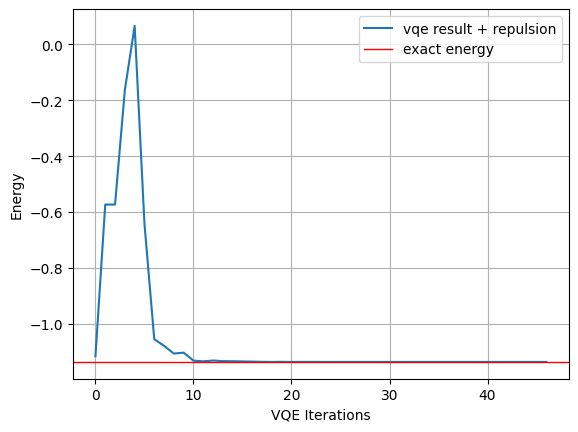

0.7151043390810812 -1.1372838344885012 -1.137283818116955


In [5]:
plt.plot(intermediate_info['energy '] + repulsion, label = 'vqe result + repulsion')
plt.axhline(y = exact_arr[-1], color = 'r', linewidth = 1, label = 'exact energy')
plt.xlabel('VQE Iterations')
plt.ylabel('Energy')
plt.grid()
plt.legend()
plt.show()
print(repulsion, exact_arr[-1], intermediate_info['energy '][-1] + repulsion)

/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:61: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.numpy_minimum_eigen_solver.NumPyMinimumEigensolver`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.NumPyMinimumEigensolver``. See https://qisk.it/algo_migration for a migration guide.
/root/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated 

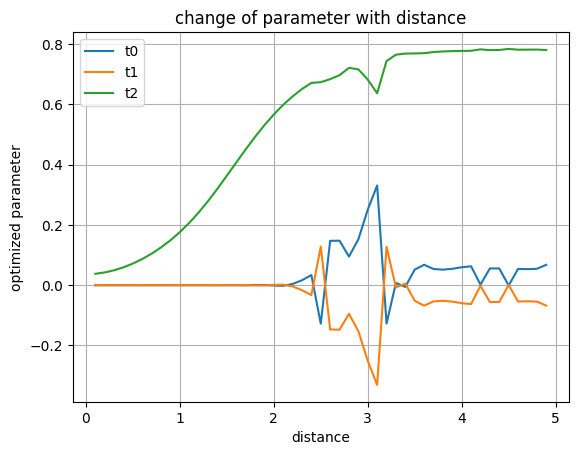

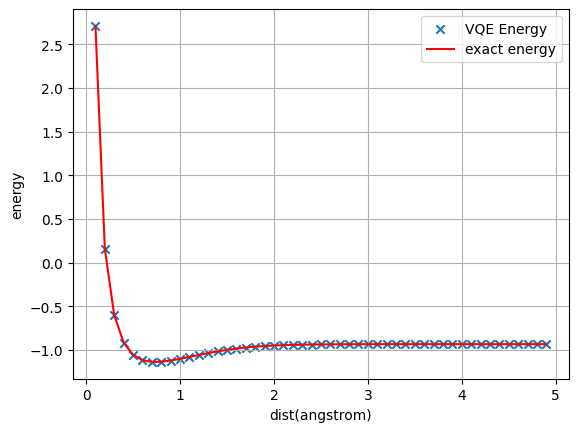

In [6]:
d_arr =[]
e_arr =[]
t0_arr = []
t1_arr = []
t2_arr = []
exact_arr = []
repulsive_arr = []
qoulomb_arr = []

distance = np.arange(0.1,5,0.1)
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
freeze_core=True
t0_arr = []
t1_arr = []
t2_arr = []

for dist in distance:
    driver = PySCFDriver ( atom ="H .0 .0 .0; H .0 .0 " + str( dist ), unit = UnitsType. ANGSTROM , charge =0, spin =0, basis = basis )
    settings.dict_aux_operators = True

    problem = ElectronicStructureProblem(driver)
    second_q_ops = problem.second_q_ops()
    FermionicOp.set_truncation(0)
    main_op = second_q_ops['ElectronicEnergy']

    particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_particles = (particle_number.num_alpha, particle_number.num_beta)
    num_orbitals = particle_number.num_spin_orbitals
    qubitOp = converter.convert(main_op, num_particles=num_particles,)

    init_state = HartreeFock(num_orbitals, num_particles, converter)
    ansatz = UCCSD(qubit_converter=converter, num_particles=num_particles, num_spin_orbitals=num_orbitals, initial_state=init_state)
    vqe = VQE(ansatz , optimizer , callback = callback, quantum_instance = quantum_instance )


    result = vqe.compute_minimum_eigenvalue(qubitOp)
    electronic_structure_result = problem.interpret(result)
    #핵 간의 밀어내는 에너지를 얻어낸다. (이는 전자의 구조에 의해 변하지 않는 일정한 값이다.)
    shift = electronic_structure_result.nuclear_repulsion_energy
    #최종 에너지 계산값
    vqe_result = result.eigenvalue.real #+shift
    qoulomb = vqe_result
    repulsion = shift
    energy = qoulomb + repulsion
    exact_energy = exact_solver(qubitOp, problem).total_energies[0].real
    qoulomb_arr.append(qoulomb)
    repulsive_arr.append(repulsion)
    d_arr.append(dist)
    e_arr.append(energy)
    exact_arr.append(exact_energy)

    p1 = intermediate_info['parameters '][-1][0]
    p2 = intermediate_info['parameters '][-1][1]
    p3 = intermediate_info['parameters '][-1][2]
    t0_arr.append(p1)
    t1_arr.append(p2)
    t2_arr.append(p3)


plt.plot(distance,t0_arr,label='t0')
plt.plot(distance,t1_arr,label='t1')
plt.plot(distance,t2_arr,label='t2')
plt.xlabel('distance')
plt.ylabel('optimized parameter')
plt.title('change of parameter with distance')
plt.grid()
plt.legend()
plt.show()


#plt.plot(d_arr,qoulomb_arr,label ='vqe_result')
#plt.plot(d_arr,repulsive_arr, label = 'repulsion')
plt.scatter(d_arr,e_arr,marker='x', label = 'VQE Energy')
plt.plot(d_arr,exact_arr,label = 'exact energy',color='red')
plt.grid()
plt.legend()
plt.xlabel("dist(angstrom)")
plt.ylabel('energy')
plt.show()

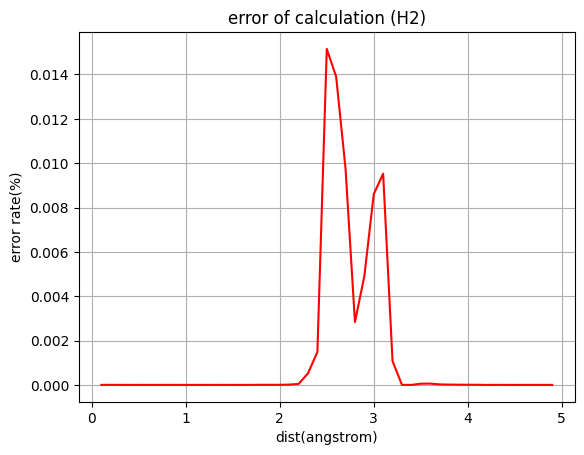

In [7]:
error=[]
for k in np.arange(len(d_arr)):
    err = e_arr[k]-exact_arr[k]
    erro = np.abs(100*err/exact_arr[k])
    error.append(erro)


plt.plot(d_arr,error,color='red')
plt.title("error of calculation (H2)")
plt.grid()
plt.xlabel("dist(angstrom)")
plt.ylabel('error rate(%)')
plt.show()

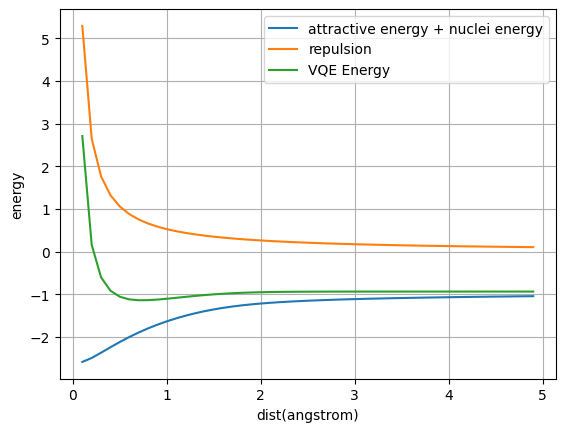

In [8]:
plt.plot(d_arr,qoulomb_arr,label ='attractive energy + nuclei energy')
plt.plot(d_arr,repulsive_arr, label = 'repulsion')
plt.plot(d_arr,e_arr, label = 'VQE Energy')

plt.grid()
plt.legend()
plt.xlabel("dist(angstrom)")
plt.ylabel('energy')
plt.show()

In [9]:
print(len(intermediate_info['parameters '][0]))

3


In [10]:
12000/92

130.43478260869566